# Example: OOI Profiler Data

In order to use the OOI utility functions, you first need to put your OOI API credentials in a .netrc file in your home directory. The .netrc entry should look like this:

```
machine ooinet.oceanobservatories.org
login your_ooi_username
password your_ooi_token
```


The Ocean Observatories Initiative has assigned the ACS Spectrophotometer with the generic name of OPTAA (Optical Absorption and Attenuation). Currently, OPTAAC, OPTAAD, and OPTAAJ are the "types" for the sensor. 
The only difference between the C, D, and J variants are the deployment locations and the housing depth limitations. OPTAAC and OPTAAD indicate that the ACS is located at fixed depth on a fixed location platform. OPTAAJ denotes that the sensor is located on a profiler.
They all produce the same data and would use acspype in the same processing steps.

In this example, we will use OPTAAJ and ECO-Triplet Fluorometer (FLORTJ) data from the Oregon Shelf Surface Piercing Profiler (CE02SHSP) Deployment 13. The data in this example was downloaded from the OOI GoldCopy Catalog, which contains the most up-to-date versions of OOI data. acspype.utils.ooi provides a convenience function for downloading a OOI THREDDS file.

Information about the OPTAA dataset, including the download URL, can be found here:
https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/catalog.html?dataset=ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc

Information about the FLORT datase, including the download URL, can be found here:
https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHSP-SP001-07-FLORTJ000-recovered_cspp-flort_sample/catalog.html?dataset=ooigoldcopy/public/CE02SHSP-SP001-07-FLORTJ000-recovered_cspp-flort_sample/deployment0013_CE02SHSP-SP001-07-FLORTJ000-recovered_cspp-flort_sample_20190624T165545.113000-20190627T023924.529000.nc

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

from acspype import ACSTSCor
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype.experimental import compute_chl_alh
from acspype.utils.ooi import download_and_load_goldcopy, reformat_ooi_optaa, get_ooi_optaa_cal

## Reformat Data and Load Calibration/Correction Coefficients

ACS data from the OOI is conveniently stored in netCDFs. However, the OOI stores the device files in a separate location than the file metadata. The device file can be accessed in its text file form (.dev) through the OOI Alfresco, but searching for the correct file can be hasslesome. Instead, we will use the OOI API to access the calibration information we need using the UID provided in the netCDF file and the calibration information that occurs closes to the first timestamp in the dataset.


In the provided function `get_ooi_optaa_cal`, the appropriate calibration information is accessed from the API. Since the OOI does not provide all of the device file information through the API, the function also assumes a path length of 0.25m and build interpolation function for delta T. The output class attributes are in the same format as the return for an `ACSDev` object.

In [2]:
acs_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc'
acs = download_and_load_goldcopy(acs_url)

The format of the OPTAA files provided by the OOI is not conducive to merging and is not compatible with acspype. The OOI provides a `wavelength` dimension in the files that is not representative of the wavelength at all. The `reformat_ooi_optaa` function will reformat the data to have the dimensions of time, a_wavelength, and c_wavelength. It will also rename some function to provide more clarity. In some OPTAA datasets, the elapsed time of the sensor is called "elapsed_run_time" which has units of milliseconds, while others have "on_seconds" which has units of seconds. The `reformat_ooi_optaa` function will also convert these variable to 'elapsed_time' in milliseconds.


The OOI also provides nearest neighbor values for sea water temperature, sea water practical salinity, and sea water pressure, so we do not need to merge and matchup that ancillary data on our own.

In [3]:
dev = get_ooi_optaa_cal(acs)

In [4]:
acs = reformat_ooi_optaa(acs)

In [5]:
print(acs.dims)
print(acs.data_vars)

FrozenMappingWarningOnValuesAccess({'latitude': 1, 'longitude': 1, 'deployment': 1, 'time': 131979, 'a_wavelength': 86, 'c_wavelength': 86})
Data variables:
    a_m_discontinuity             (latitude, longitude, deployment, time, a_wavelength) float64 91MB ...
    a_reference                   (latitude, longitude, deployment, time, a_wavelength) float32 45MB ...
    a_reference_dark_counts       (latitude, longitude, deployment, time) float32 528kB ...
    a_signal                      (latitude, longitude, deployment, time, a_wavelength) float32 45MB ...
    a_signal_dark                 (latitude, longitude, deployment, time) float32 528kB ...
    c_m_discontinuity             (latitude, longitude, deployment, time, c_wavelength) float64 91MB ...
    c_reference                   (latitude, longitude, deployment, time, c_wavelength) float32 45MB ...
    c_reference_dark              (latitude, longitude, deployment, time) float32 528kB ...
    c_signal                      (latitud

Since we are going to reprocess the ACS data, we can drop the variables the OOI already processes.

In [6]:
acs = acs.drop_vars(['a_m_discontinuity','c_m_discontinuity'], errors = 'ignore')

Since all OOI OPTAA assets are currently on static platforms, the latitude, longitude, and deployment values for each file are scalar, meaning they can be assigned as dimensions rather than variables. `reformat_ooi_optaa` does this, meaning we will need to select the data by those values to produce a format that acspype can handle.

In [7]:
lat = float(acs.latitude)
lon = float(acs.longitude)
deployment = int(acs.deployment)
acs = acs.sel(latitude = lat, longitude = lon, deployment = deployment)

The TS coefficients provided by Sullivan et al. (2006) and interpolated by SBS in the TS4.cor file have been pickled to allow for direct access through acspype and can be called by instantiating the `ACSTSCor` class. 

In [8]:
tscor = ACSTSCor()

## Reprocess the Data

In [9]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(acs['raw_internal_temperature'])
acs['external_temperature'] = acsproc.compute_external_temperature(acs['raw_external_temperature'])

In [10]:
acs['a_uncorrected'] = acsproc.compute_uncorrected(acs['a_signal'], acs['a_reference'], dev)
acs['c_uncorrected'] = acsproc.compute_uncorrected(acs['c_signal'], acs['c_reference'], dev)

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [11]:
acs['a_m_discontinuity'] = acsproc.compute_measured(acs['a_uncorrected'], 'a', acs['internal_temperature'], dev)
acs['c_m_discontinuity'] = acsproc.compute_measured(acs['c_uncorrected'], 'c', acs['internal_temperature'], dev)

In [12]:
discontinuity_index = acsproc.find_discontinuity_index(acs['a_wavelength'], acs['c_wavelength'])
acs['a_m'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(acs.a_m_discontinuity, 'a_wavelength', discontinuity_index)
acs['c_m'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(acs.c_m_discontinuity, 'c_wavelength', discontinuity_index)

In [13]:
acs['a_mts'] = acsproc.ts_correction(acs.a_m, 'a', acs.sea_water_temperature, acs.sea_water_practical_salinity, dev, tscor)
acs['c_mts'] = acsproc.ts_correction(acs.c_m, 'c', acs.sea_water_temperature, acs.sea_water_practical_salinity, dev, tscor)

In [14]:
acs['a_mts'] = acsproc.zero_shift(acs.a_mts)
acs['c_mts'] = acsproc.zero_shift(acs.c_mts)

## Flag Data

In [15]:
fail = 10 * 1000
suspect = 3*60*1000
acs['flag_elapsed_time'] = acsqaqc.elapsed_time_test(acs['elapsed_time'], fail_threshold=fail, suspect_threshold=suspect)

In [16]:
acs['flag_internal_temperature'] = acsqaqc.internal_temperature_test(acs['internal_temperature'], dev)

In [17]:
acs['flag_inf_nan_a_uncorrected'] = acsqaqc.inf_nan_test(acs.a_uncorrected)
acs['flag_inf_nan_c_uncorrected'] = acsqaqc.inf_nan_test(acs.c_uncorrected)

## Remove Poor Data

In [18]:
acs = acs.where(acs.flag_elapsed_time != 4, drop = True) # Drop any and all data where the elapsed time does not pass the elapsed time test.
acs = acs.where(acs.flag_internal_temperature != 4, drop = True)  # Drop any and all data where the internal temperature of the sensor exceeded the calibration range defined in the device file.
acs = acs.where(acs.flag_inf_nan_a_uncorrected != 4, drop = True)  
acs = acs.where(acs.flag_inf_nan_c_uncorrected != 4, drop = True)

In [19]:
acs = acsproc.interpolate_common_wavelengths(acs)

In [20]:
acs['a_mts_proportional'] = acsproc.scattering_correction_proportional(acs.a_mts, acs.c_mts)

In [21]:
acs['chl_alh'] = compute_chl_alh(acs['a_mts_proportional'])

# Merge with Fluorometer Data using Nearest Neighbor
This will produce same consecutive values for the fluorometer data. 

In [22]:
flort_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSP-SP001-07-FLORTJ000-recovered_cspp-flort_sample/deployment0013_CE02SHSP-SP001-07-FLORTJ000-recovered_cspp-flort_sample_20190624T165545.113000-20190627T023924.529000.nc'
flort = download_and_load_goldcopy(flort_url)
flort = flort.swap_dims({'obs': 'time'})
flort = flort.drop_vars(['depth','deployment','obs'])
flort = flort['fluorometric_chlorophyll_a']
flort = flort.interp(time = acs.time, method = 'nearest')

In [23]:
acsm = xr.combine_by_coords([acs, flort], combine_attrs='drop_conflicts')

## Split Into Profiles
OOI profiler data is not distributed to the end-user with a unique ID for each profile. Here, lets assume that the minimum time between profiles is 15 minutes.

In [24]:

def split_profiles(ds):
    """
    Split the data set into individual profiles, where each profile is a
    collection of data from a single deployment and profile sequence. The
    resulting data sets are returned in a list.

    :param ds: data set containing the profile data
    :return: a list of data sets, one for each profile
    """
    # split the data into profiles, assuming at least 120 seconds between profiles
    dt = ds.where(ds['time'].diff('time') > np.timedelta64(120, 's'), drop=True).get_index('time')

    # process each profile, adding the results to a list of profiles
    profiles = []
    jback = np.timedelta64(30, 's')  # 30 second jump back to avoid collecting data from the following profile
    for i, d in enumerate(dt):
        # pull out the profile
        if i == 0:
            profile = ds.sel(time=slice(ds['time'].values[0], d - jback))
        else:
            profile = ds.sel(time=slice(dt[i - 1], d - jback))

        # add the profile to the list
        profiles.append(profile)

    # grab the last profile and append it to the list
    profile = ds.sel(time=slice(d, ds['time'].values[-1]))
    profiles.append(profile)
    return profiles


def bin_profiles(profile, site_depth, bin_size=0.25):
    """
    Bin the data in the profile into a set of bins of a given size (default is
    25 cm). The bin depth is set to the center of the bin, using the median
    value of the data in each bin.

    :param profile: data set containing the profile data
    :param site_depth: maximum depth of the site, used to set binning range
    :param bin_size: size of the bin, in meters
    :return: a data set containing the binned data
    """
    # test the length of the profile, short ones with less than 15 records will be skipped
    if len(profile.time) < 15:
        return None

    # test the time range of the profile, short ones (less than 15 seconds) will be skipped
    if (profile.time[-1] - profile.time[0]).astype(float) / 10 ** 9 < 15:
        return None

    # use a set of median boxcar filters to help despike the data
    smth = profile.rolling(time=5, min_periods=3, center=True).median(keep_attrs=True).dropna("time", subset=['deployment'])
    smth = smth.rolling(time=5, min_periods=3, center=True).median(keep_attrs=True).dropna("time", subset=['deployment'])

    # bin the data using the center of the bin as the depth value
    bins = smth.groupby_bins('depth', np.arange(bin_size / 2, site_depth + bin_size / 2, bin_size))
    binning = []
    for grp in bins:
        avg = grp[1].mean('time', keepdims=True, keep_attrs=True)
        avg = avg.assign_coords({'time': np.atleast_1d(grp[1].time.mean().values)})  # add time back
        avg['depth'] = avg['depth'] * 0 + grp[0].mid  # set depth to bin midpoint
        binning += avg,  # append to the list

    binned = xr.concat(binning, 'time')
    return binned


In [25]:
profiles = split_profiles(acsm)
p = profiles[50]
p = p.rolling({'time': 13}, center = True).median(skipna = True)

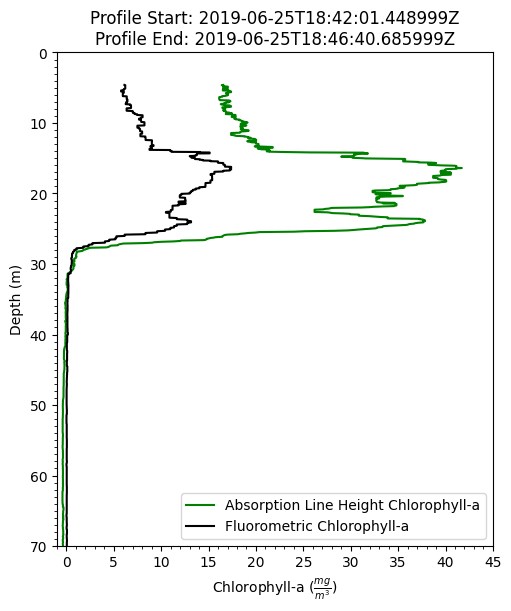

In [26]:
fig, ax = plt.subplots(1,1, figsize = (5,6), sharey = True, constrained_layout = True)

ax.plot(p.chl_alh, p.depth, label = 'Absorption Line Height Chlorophyll-a', color = 'green',)
ax.plot(p.fluorometric_chlorophyll_a, p.depth, label = 'Fluorometric Chlorophyll-a', color = 'black')
ax.legend(loc = 'lower right')
ax.set_ylim(0,70)
ax.invert_yaxis()

ax.set_xlim(-1, 45)

ax.set_ylabel('Depth (m)')
ax.set_xlabel(r'Chlorophyll-a ($\frac{mg}{m^3}$)')

ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))

ax.set_title('Profile Start: ' + p.time.min().values.astype(str)[:-3] + 'Z' + '\nProfile End: ' + p.time.max().values.astype(str)[:-3] + 'Z')

plt.savefig('ooi_ce02shsp_profile.png', dpi = 600)